## Obligatory imports

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (1.5,1)

# We use the MNIST Dataset again

In [3]:
import IPython
url = 'http://yann.lecun.com/exdb/mnist/'
iframe = '<iframe src=' + url + ' width=80% height=400px></iframe>'
IPython.display.HTML(iframe)

## Fetch the data

In [4]:
from sklearn.datasets import fetch_mldata

In [8]:
mnist = fetch_mldata('MNIST original', data_home='../day4/data/')

In [9]:
allimages = mnist.data
allimages.shape

(70000, 784)

In [10]:
all_image_labels = mnist.target
set(all_image_labels)

{0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0}

## check out the data

In [11]:
digit1 = mnist.data[0,:].reshape(28,-1) # arr.reshape(4, -1) is equivalent to arr.reshape(4, 7), is arr has size 28

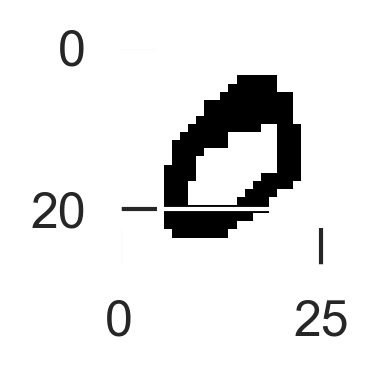

In [12]:
plt.imshow(digit1, vmin=0, vmax=1)

## Classify using SVM
**SVM tries to draw planes that maximizes the gap between differently labelled datasets.**
![image](http://scikit-learn.org/stable/_images/sphx_glr_plot_separating_hyperplane_0011.png)

### Imporatnt tunable parameters

* **C:** the regularization parameter. Identical to Logistic Regression. |
* **kernel:** "Bends" the plane into curved shapes. Default: 'rbf' AKA Gaussian.|

### Kernel specific parameters
* **linear:** None
* **rbf** 
    - **gamma** High means each training data doesn't easily affect others. 
* **polynomial**
    - **degree**
    - **r**
    
The task of finding optimum parameter values can be very cumbersome, and the classifier score may vary wildly based on them.
We will see later, there's a simple technique called parameter grid search to aid this task.

### Separate the data into training data and test data

In [13]:
len(allimages)

70000

### Sample the data, 70000 is too many images to handle on a single PC

In [14]:
len(allimages)

70000

In [15]:
size_desired_dataset = 2000

In [16]:
sample_idx = np.random.choice(len(allimages), size_desired_dataset)
images = allimages[sample_idx, :]
image_labels = all_image_labels[sample_idx]

In [17]:
set(image_labels)

{0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0}

In [18]:
image_labels.shape

(2000,)

### Partition into training and test set *randomly*

**As a rule of thumb, 80/20 split between training/test dataset is often recommended.**
See below for cross validation and how that changes this thumbrule.


In [19]:
from scipy.stats import itemfreq

In [20]:
from sklearn.model_selection import train_test_split

In [21]:
training_data, test_data, training_labels, test_labels = train_test_split(images, image_labels, train_size=0.8)

** Importance of normalization** 
If  Feature A is in the range [0,1] and Feature B is in [10000,50000], SVM (in fact, most of the classifiers) will suffer inaccuracy.
The solution is to *normalize* (AKA "feature scaling") each feature to the same interval e.g. [0,1] or [-1, 1].

**scipy provides a standard function for this:**

In [42]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
# Fit only to the training data: IMPORTANT
scaler.fit(training_data)

StandardScaler(copy=True, with_mean=True, with_std=True)

In [23]:
from sklearn.svm import SVC

In [24]:
clf = SVC()
clf.fit(scaler.transform(training_data), training_labels)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [25]:
clf.score(scaler.transform(test_data), test_labels)

0.87

**The score is horrible!** We must tune the parameters $C$ and gamma. `sklearn` provides a handy tool to search through many possible parameter combinations.

## Parameter space search with `GridSearchCV`

In [28]:
from sklearn.model_selection import GridSearchCV

In [29]:
image_labels.shape

(2000,)

In [30]:
svr = SVC()

In [35]:
clf = GridSearchCV(svr, {'C':np.logspace(-4, 8, 6), 'gamma':np.logspace(-8,-4,4)}, n_jobs = -1)

In [36]:
clf.fit(scaler.transform(images), image_labels)

GridSearchCV(cv=None, error_score='raise',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'C': array([  1.00000e-04,   2.51189e-02,   6.30957e+00,   1.58489e+03,
         3.98107e+05,   1.00000e+08]), 'gamma': array([  1.00000e-08,   2.15443e-07,   4.64159e-06,   1.00000e-04])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [39]:
clf.best_params_

{'C': 1584.8931924611109, 'gamma': 4.6415888336127726e-06}

In [40]:
clf.best_score_

0.88249999999999995

In [43]:
svm_tuned = clf.best_estimator_
svm_tuned.fit(scaler.transform(training_data), training_labels)

SVC(C=1584.8931924611109, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma=4.6415888336127726e-06,
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)


Like **Logistic regression**, SVM also draws a **decision boundary**

 ![what](http://scikit-learn.org/stable/_images/sphx_glr_plot_iris_0012.png)

## How to detect overfitting: Cross validation and learning curve

In [44]:
import pandas as pd

In [45]:
from sklearn.model_selection import learning_curve

In [46]:
curve = learning_curve(svm_tuned, scaler.transform(images), image_labels, train_sizes= np.linspace(0.03, 0.99, 10), cv = 18, n_jobs = 12)

In [47]:
train_sizes, train_scores, test_scores = curve

In [48]:
train_scores = pd.DataFrame(train_scores)
train_scores.loc[:,'train_size'] = train_sizes
test_scores = pd.DataFrame(test_scores)
test_scores.loc[:,'train_size'] = train_sizes

In [49]:
train_scores.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,train_size
0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,56
1,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,257
2,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,458
3,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,660
4,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,861


In [50]:
train_scores = pd.melt(train_scores, id_vars=['train_size'], value_name = 'CrossVal score')
test_scores = pd.melt(test_scores, id_vars=['train_size'], value_name = 'CrossVal score')

In [51]:
train_scores.head()

,train_size,variable,CrossVal score
0,56,0,1.0
1,257,0,1.0
2,458,0,1.0
3,660,0,1.0
4,861,0,1.0


(0, 1.1)

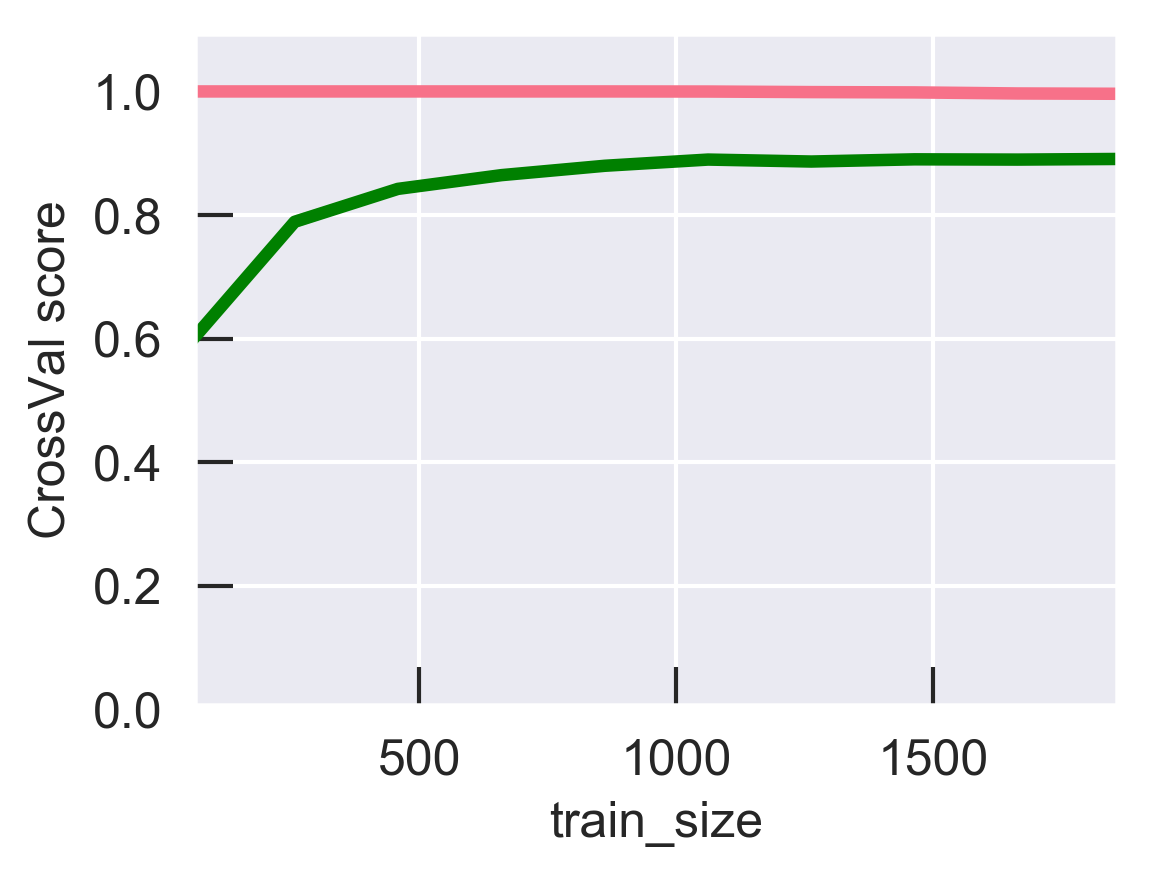

In [52]:
matplotlib.rcParams['figure.figsize'] = (4,3)
sns.tsplot(train_scores, time = 'train_size', unit='variable', value = 'CrossVal score')
sns.tsplot(test_scores, time = 'train_size', unit='variable', value = 'CrossVal score', color='g')
plt.ylim(0,1.1)

This is a significan increase in quality than logistic regression.

Finding optimum parameters for advanced classifiers is not always so straightforward, and quite often the most time consuming part. This so-called **Hyperparameter optimization** is a topic in itself, and has numerous approaches and libraries. 

* [http://neupy.com/2016/12/17/hyperparameter_optimization_for_neural_networks.html](http://neupy.com/2016/12/17/hyperparameter_optimization_for_neural_networks.html)
* [Practical Bayesian Optimization of Machine Learning Algorithms](https://dash.harvard.edu/handle/1/11708816)

# Exercise

## iris dataset
Train an SVM with different kernels (linear, rdf) on the `iris` dataset and run cross validation. Do not forget to normalize the featurs. 
Compare the results against LogisticRegression.

Use Grid search to tune the SVM further. How high up can you get the test scores?

## Further reading
* http://www.ritchieng.com/applying-machine-learning/
    